In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#print("Device:", tpu.master())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133 kB 16.0 MB/s 


In [2]:
pip install clean-text[gpl]


     |████████████████████████████████| 175 kB 14.7 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 235 kB 75.4 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=54b8660cb67104416e48c7c4848f2ae6dbdffe82a709006c64b374a91b1d8738
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
from cleantext import clean

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#Read in data
path_to_csv = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/cyberbullying_tweets.csv'
df=pd.read_csv(path_to_csv)

# Cleaning and Organizing Data

In [8]:
#looking at original data observation with emojis and urls

df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [9]:
#function for cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="") #removing emojies and urls 
    return text



In [10]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [11]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojies or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,uh. why do they not make these for grownups?,not_cyberbullying
1040,omg i have a feeling i'm going to be overwhelmed by my emoticons in tomorrow's #mkr,not_cyberbullying


In [12]:
#dropping duplicates
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45603, 2)

In [13]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7974
age                    7952
ethnicity              7946
other_cyberbullying    7720
gender                 7651
not_cyberbullying      6360
Name: cyberbullying_type, dtype: int64

In [14]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

In [15]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7974
1    7952
3    7946
5    7720
2    7651
4    6360
Name: label_values, dtype: int64

In [16]:
#Splitting dataset into full_train and test sets, stratifying on labels.

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [17]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7100
1    7080
3    7075
5    6873
2    6812
4    5663
Name: label_values, dtype: int64

In [18]:
#making sure test set is stratified properly
y_test.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

In [19]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [20]:
#making sure train set is stratified properly
y_train.value_counts()

0    6226
1    6208
3    6204
5    6026
2    5973
4    4966
Name: label_values, dtype: int64

In [21]:
#making sure validation set is stratified properly
y_val.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

# Data Preprocessing and Tokenization

In [22]:
#Tokenized text for X_train and X_val and X_test. Fit on train first then text_to_sequences on train,
#validation and test sets
max_tokens=30000
tokenizer =Tokenizer(num_words=max_tokens, oov_token="OOV")
tokenizer.fit_on_texts(X_train)
X_train_token=tokenizer.texts_to_sequences(X_train)
X_val_token=tokenizer.texts_to_sequences(X_val)
X_test_token=tokenizer.texts_to_sequences(X_test)

In [23]:
#check how many unique tokens
word_index=tokenizer.word_index
number_of_words=len(word_index)
print("Number of tokens",number_of_words )

Number of tokens 49098


In [24]:
#pad sequences for tokenized X_train, X_val and X_test
#set max length of text to 70 tokens
max_len=70
X_train_token_pad=pad_sequences(X_train_token, maxlen=max_len, padding="post", truncating="post")

#Get train shape to apply as max length of validation padding
#train_tensor_shape=X_train_token_pad.shape[1]
#train_tensor_shape

X_val_token_pad=pad_sequences(X_val_token,maxlen= max_len , padding="post", truncating="post")
X_test_token_pad=pad_sequences(X_test_token,maxlen= max_len,padding="post", truncating="post")
X_val_token_pad.shape

(5000, 70)

# Helpful Model Fitting and Results Functions

In [25]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [26]:

def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3, optimizer='adam'):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=128,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
        
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                        
  

    return history, model   

In [27]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [28]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [29]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [30]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ["religion",
                       "age",
                       "gender",
                       "ethnicity",
                       "not_cyberbullying",
                       "other_cyberbullying"
]



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# GloVe Embeddings: Parsing and Creating Embedding Matrix

In [31]:

path_to_glove_file = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/glove.twitter.27B.100d.txt'
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 1193514 word vectors.


In [32]:
embedding_dim = 100



# Prepare a matrix for the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

# Experiment 5_A - GloVe Pre-trained Embeddings - Bidirectional LSTM - Hyperparameter Tuning - Up to 3 Bidirectional LSTM Layers with Dropout

In [33]:
#Experiment 5_A model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_5_A(hp):
    
    model=Sequential()
    model.add(Embedding(max_tokens, 100,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
        ))
    
    #tunning for a choice of 1 or 2 bidirectional LSTM layers. There is an additional bidirectional LSTM layer that must be outside the loop as it needs
    #to not have return_sequences =True
   
    for i in range(hp.Int("number_layers",1,2)):
        #within each bidirectional LSTM layer testing for a min of 64 units, a max of 256 nodes and any in between by 
        #multiples of 32. 
        model.add(Bidirectional(LSTM(units=hp.Int('LSTM_{}_units'.format(i),min_value=64,max_value=256,step=32),return_sequences=True)))
        #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
        model.add(Dropout (hp.Float("dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
        
    #For last bidirectional LSTM layer testing for a min of 64 units, a max of 256 nodes and any in between by 
    #multiples of 32
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_{}_units'.format(i+1),min_value=64,max_value=256,step=32))))
    #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
    model.add(Dropout (hp.Float("dropout_{}".format(i+1), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation="softmax"))    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [34]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_5_A = kt.BayesianOptimization(
    hypermodel=create_model_exp_5_A,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_5_A")

In [35]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="5_A"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_5_A.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 03m 49s]
val_accuracy: 0.871999979019165

Best val_accuracy So Far: 0.8781999945640564
Total elapsed time: 00h 44m 39s
INFO:tensorflow:Oracle triggered exit


In [36]:
#getting best hyperparameters
best_hyper_parameters_exp_5_A=tuner_exp_5_A.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many bidirectional LSTM layers there are
def best_model_hyperparameters_exp_5_A(bhp):
    
    num_layers=bhp.get('number_layers')
    print("Number of layers: {}".format(num_layers+1))
    print("\n")
    for i in range(0,num_layers+1):
        print("Number of units in LSTM_{}:".format(i), bhp.get("LSTM_{}_units".format(i)))
        print("Dropout in LSTM_{}:".format(i),np.round( bhp.get("dropout_{}".format(i)),3 )  )
        print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_exp_5_A(best_hyper_parameters_exp_5_A)   

Number of layers: 3


Number of units in LSTM_0: 192
Dropout in LSTM_0: 0.4


Number of units in LSTM_1: 64
Dropout in LSTM_1: 0.4


Number of units in LSTM_2: 256
Dropout in LSTM_2: 0.4


Optimizer Used: adam


In [37]:
#getting paremeters of best model
model_exp_5_A_best_params = tuner_exp_5_A.get_best_hyperparameters(2)

# Building model exp_5_A with best hyper parameters
model_exp_5_A_best = create_model_exp_5_A(model_exp_5_A_best_params[0])

# Running best model 5_A to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=3
model_number="5_A"
history_exp_5_A, model_exp_5_A = compile_train_model(model_exp_5_A_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="adam")

Epoch 1/30
279/279 [==============================] - 45s 87ms/step - loss: 0.6328 - accuracy: 0.7651 - val_loss: 0.4697 - val_accuracy: 0.8300
Epoch 2/30
279/279 [==============================] - 17s 63ms/step - loss: 0.4307 - accuracy: 0.8411 - val_loss: 0.3934 - val_accuracy: 0.8538
Epoch 3/30
279/279 [==============================] - 17s 62ms/step - loss: 0.3856 - accuracy: 0.8562 - val_loss: 0.3656 - val_accuracy: 0.8626
Epoch 4/30
279/279 [==============================] - 18s 63ms/step - loss: 0.3506 - accuracy: 0.8671 - val_loss: 0.3610 - val_accuracy: 0.8694
Epoch 5/30
279/279 [==============================] - 17s 62ms/step - loss: 0.3279 - accuracy: 0.8757 - val_loss: 0.3576 - val_accuracy: 0.8672
Epoch 6/30
279/279 [==============================] - 18s 63ms/step - loss: 0.3055 - accuracy: 0.8844 - val_loss: 0.3506 - val_accuracy: 0.8720
Epoch 7/30
279/279 [==============================] - 18s 64ms/step - loss: 0.2870 - accuracy: 0.8913 - val_loss: 0.3998 - val_accuracy:

In [38]:
model_exp_5_A.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         3000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 384)        450048    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, None, 384)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        229888    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)             

In [39]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5_A, model_number, epochs, patience=patience)

Model Experiment 5_A  Training Loss:  0.272
Model Experiment 5_A  Training Accuracy:  0.8985
Model Experiment 5_A  Validation Loss:  0.3609
Model Experiment 5_A  Validation Accuracy: 0.8732


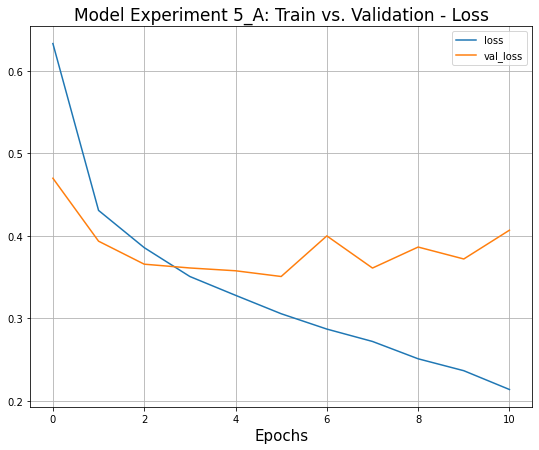

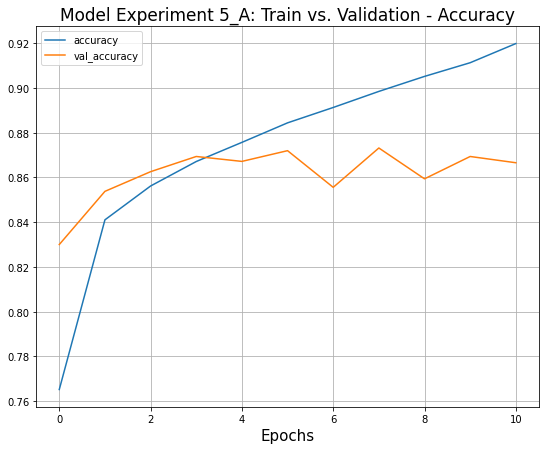

In [40]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5_A, model_number)

In [41]:
#creating  classification report

#getting predictions

model_exp_5_A_predictions=model_exp_5_A.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_5_A_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       874
           1       0.97      0.99      0.98       872
           2       0.85      0.87      0.86       839
           3       0.98      0.98      0.98       871
           4       0.76      0.55      0.64       697
           5       0.70      0.83      0.76       847

    accuracy                           0.87      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.87      0.87      5000

Accuracy Score: 0.8732
Root Mean Square Error: 0.8370185183136631


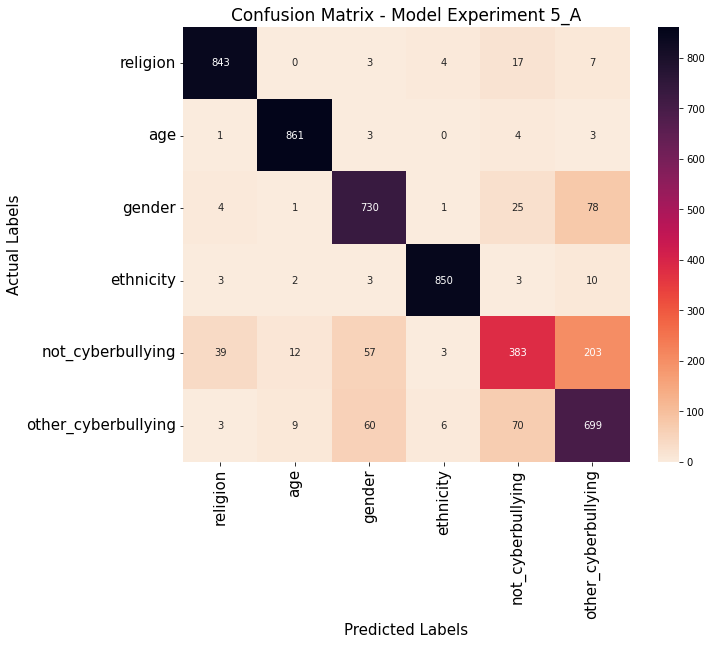

In [42]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5_A, X_test_token_pad, y_test, model_number)

In [44]:
keras.backend.clear_session()

# Experiment 5_B - GloVe Pre-trained Embeddings - Bidirectional GRU - Hyperparameter Tuning - Up to 3 Bidirectional GRU Layers with Dropout

In [45]:
#Experiment 5_B model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_5_B(hp):
    
    model=Sequential()
    model.add(Embedding(max_tokens, 100,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
        ))
    
    #tunning for a choice of 1 or 2 bidirectional GRU layers. There is an additional bidirectional GRU layer that must be outside the loop as it needs
    #to not have return_sequences =True
    #last_GRU_Layer_number=0
    for i in range(hp.Int("number_layers",1,2)):
        #within each bidirectional GRU layer testing for a min of 64 units, a max of 256 nodes and any in between by 
        #multiples of 32. 
        model.add(Bidirectional(GRU(units=hp.Int('GRU_{}_units'.format(i),min_value=64,max_value=256,step=32),return_sequences=True)))
        #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
        model.add(Dropout (hp.Float("dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
        #last_GRU_Layer_number+=1
    #For last bidirectional GRU layer testing for a min of 64 units, a max of 256 nodes and any in between by 
    #multiples of 32
    model.add(Bidirectional(GRU(units=hp.Int('GRU_{}_units'.format(i+1),min_value=64,max_value=256,step=32))))
    #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
    model.add(Dropout (hp.Float("dropout_{}".format(i+1), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation="softmax"))    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [46]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_5_B = kt.BayesianOptimization(
    hypermodel=create_model_exp_5_B,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    #distribution_strategy=strategy_exp_5_B,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_5_B")

In [47]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="5_B"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_5_B.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 02m 08s]
val_accuracy: 0.8772000074386597

Best val_accuracy So Far: 0.8808000087738037
Total elapsed time: 00h 37m 53s
INFO:tensorflow:Oracle triggered exit


In [48]:
#getting best hyperparameters
best_hyper_parameters_exp_5_B=tuner_exp_5_B.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many bidirectional GRU layers there are
def best_model_hyperparameters_exp_5_B(bhp):
    
    num_layers=bhp.get('number_layers')
    print("Number of layers: {}".format(num_layers+1))
    print("\n")
    for i in range(0,num_layers+1):
        print("Number of units in GRU_{}:".format(i), bhp.get("GRU_{}_units".format(i)))
        print("Dropout in GRU_{}:".format(i),np.round( bhp.get("dropout_{}".format(i)),3 )  )
        print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_exp_5_B(best_hyper_parameters_exp_5_B)   

Number of layers: 2


Number of units in GRU_0: 64
Dropout in GRU_0: 0.4


Number of units in GRU_1: 224
Dropout in GRU_1: 0.4


Optimizer Used: adam


In [50]:
#getting paremeters of best model
model_exp_5_B_best_params = tuner_exp_5_B.get_best_hyperparameters(2)

# Building model exp_5_B with best hyper parameters
model_exp_5_B_best = create_model_exp_5_B(model_exp_5_B_best_params[0])

# Running best model 5_B to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=4
model_number="5_B"
history_exp_5_B, model_exp_5_B = compile_train_model(model_exp_5_B_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="adam")

Epoch 1/30
279/279 [==============================] - 30s 57ms/step - loss: 0.6551 - accuracy: 0.7529 - val_loss: 0.4542 - val_accuracy: 0.8298
Epoch 2/30
279/279 [==============================] - 11s 41ms/step - loss: 0.4193 - accuracy: 0.8421 - val_loss: 0.3735 - val_accuracy: 0.8552
Epoch 3/30
279/279 [==============================] - 11s 41ms/step - loss: 0.3782 - accuracy: 0.8579 - val_loss: 0.3623 - val_accuracy: 0.8630
Epoch 4/30
279/279 [==============================] - 11s 41ms/step - loss: 0.3515 - accuracy: 0.8649 - val_loss: 0.3505 - val_accuracy: 0.8662
Epoch 5/30
279/279 [==============================] - 11s 41ms/step - loss: 0.3340 - accuracy: 0.8719 - val_loss: 0.3407 - val_accuracy: 0.8714
Epoch 6/30
279/279 [==============================] - 11s 41ms/step - loss: 0.3169 - accuracy: 0.8781 - val_loss: 0.3369 - val_accuracy: 0.8752
Epoch 7/30
279/279 [==============================] - 11s 41ms/step - loss: 0.2993 - accuracy: 0.8842 - val_loss: 0.3435 - val_accuracy:

In [51]:
model_exp_5_B.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         3000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        63744     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 448)              475776    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 448)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                

In [52]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5_B, model_number, epochs, patience=patience)

Model Experiment 5_B  Training Loss:  0.2743
Model Experiment 5_B  Training Accuracy:  0.8937
Model Experiment 5_B  Validation Loss:  0.3347
Model Experiment 5_B  Validation Accuracy: 0.8776


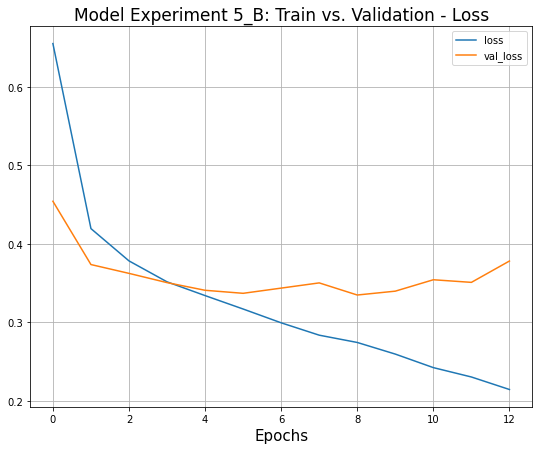

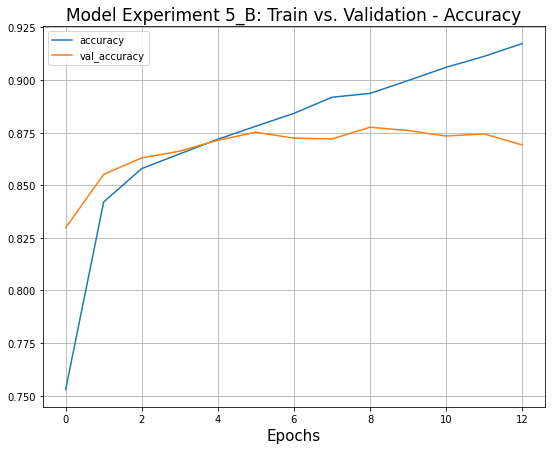

In [53]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5_B, model_number)

In [54]:
#creating  classification report

#getting predictions

model_exp_5_B_predictions=model_exp_5_B.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_5_B_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       874
           1       0.99      0.98      0.98       872
           2       0.90      0.84      0.87       839
           3       0.98      0.98      0.98       871
           4       0.70      0.63      0.66       697
           5       0.71      0.80      0.75       847

    accuracy                           0.87      5000
   macro avg       0.87      0.86      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Accuracy Score: 0.8734
Root Mean Square Error: 0.8181686867633104


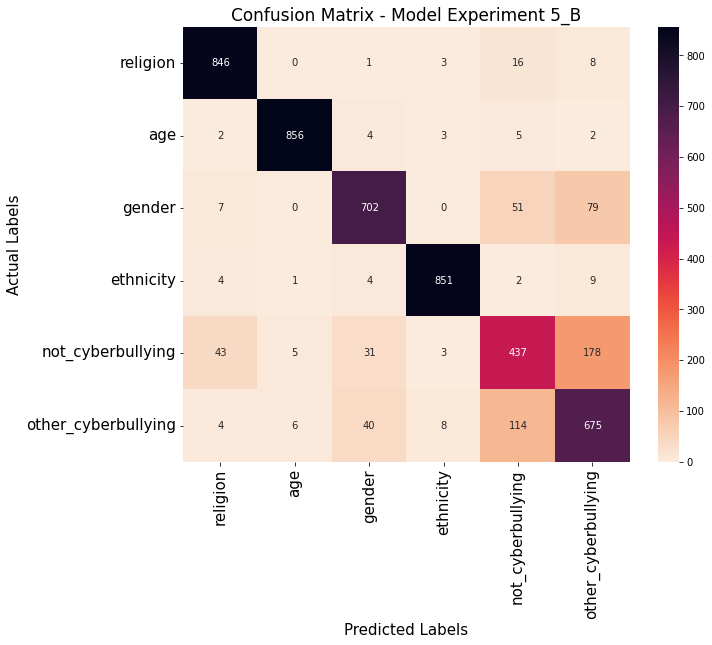

In [55]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5_B, X_test_token_pad, y_test, model_number)